## 使用gluon 进行冰川识别
kaggle 冰川比赛[链接](https://www.kaggle.com/c/statoil-iceberg-classifier-challenge)

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from subprocess import check_output
from matplotlib import pyplot as plt

%matplotlib inline

## 加载数据，并显示数据

In [2]:
data_path = 'D:/dataset/kaggle_Iceberg/'
train_path = data_path + "train.json"
test_path  = data_path + "test.json"
train_json = pd.read_json(train_path)
test_json = pd.read_json(test_path)
train_json['inc_angle'] = pd.to_numeric(train_json['inc_angle'], errors='coerce')
test_json['inc_angle'] = pd.to_numeric(test_json['inc_angle'], errors='coerce')
print (len(train_json))

1604


In [3]:
print("Train Records")
train_json.head()


Train Records


,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [4]:
print("Test Records")
test_json.head()

Test Records


,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.0589694977, -26.0589694977, -26.058969497...","[-25.7542076111, -25.7542076111, -25.754207611...",4023181e,32.615072
2,"[-14.1410999298, -15.0642414093, -17.375520706...","[-14.745639801, -14.5904102325, -14.3626976013...",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.3745937347, -26.0271816254, -28.121963501...","[-25.7223434448, -27.0115776062, -23.149162292...",4371c8c3,43.918874


## 数据增强部分
这里使用了skimage进行图像处理  
对训练数据进行随机裁剪和镜像

In [5]:
from scipy.ndimage import gaussian_filter
from skimage import img_as_float
from skimage.morphology import reconstruction
# Isolation function.
def iso(arr):
    image = img_as_float(np.reshape(np.array(arr), [75,75]))
    image = gaussian_filter(image,2)
    seed = np.copy(image)
    seed[1:-1, 1:-1] = image.min()
    mask = image 
    dilated = reconstruction(seed, mask, method='dilation')
    return image-dilated

# Feature engineering iso1 and iso2.
train_json['iso1'] = train_json.iloc[:, 0].apply(iso)
train_json['iso2'] = train_json.iloc[:, 1].apply(iso)

test_json['iso1'] = test_json.iloc[:, 0].apply(iso)
test_json['iso2'] = test_json.iloc[:, 1].apply(iso)

In [6]:
from mxnet import autograd
from mxnet import gluon
from mxnet import image
from mxnet import init
from mxnet import nd
from mxnet.gluon.data import vision

def data_norm(data):
    images = []
    for i,row in data.iterrows():
        band_1 = np.reshape(np.array(row["iso1"]).astype(np.float32),(75,75))
        band_2 = np.reshape(np.array(row["iso2"]).astype(np.float32),(75,75))
        #band_3 = (band_1+band_2)/2

        band_1_norm = (band_1-band_1.mean())/( band_1.max()-band_1.min() )
        band_2_norm = (band_2-band_2.mean() )/ (band_2.max()-band_2.min())
        #band_3_norm = band_3 / band_3.max() 
        images.append(np.stack((band_1_norm,band_2_norm)))
    return np.array(images)

def transform_train(data):
    data = nd.array(data)
    #data = (data-data.min())/(data.max()-data.min())
    auglist = image.CreateAugmenter(data_shape=(3, 75, 75), resize=0, 
                        rand_crop=True, rand_resize=True, rand_mirror=True,
                        brightness=0, contrast=0, 
                        saturation=0, hue=0, 
                        pca_noise=0, rand_gray=0, inter_method=2)
    
    for i in range(data.shape[0]):
        im = data[i,:]
        for aug in auglist:
            data[i,:] = aug(data[i,:])
    return data.asnumpy()

def transform_test(data):
    data = nd.array(data)
    auglist = image.CreateAugmenter(data_shape=(3, 75, 75))
    for i in range(data.shape[0]):
        for aug in auglist:
            data[i,:] = aug(data[i,:])
    return data.asnumpy()

def aug_img (data,aug_method):
    dataset = data_norm(data)
    dataset = np.transpose(dataset, (0,3,2,1))
    if aug_method == "train":
        dataset = transform_train(dataset) 
    elif aug_method == "test":
        dataset = transform_test(dataset)
    dataset = np.transpose(dataset, (0,3,2,1))
    return dataset

In [7]:
# X_train_total = aug_img(train_json,"train")
X_train_total = data_norm(train_json)
y_train_total = np.array(train_json['is_iceberg'])
X_angle_train_total = np.array(train_json.inc_angle)

# X_test = aug_img(test_json,"test")
X_test = data_norm(test_json)
X_angle_test = np.array(test_json.inc_angle)


In [8]:
print X_train_total.shape
print (X_train_total.min(),X_train_total.max())

(1604L, 2L, 75L, 75L)
(-0.10679642, 0.99215782)


## 验证集

In [9]:
X_train, X_valid, X_angle_train, X_angle_valid, y_train, y_valid = train_test_split(X_train_total
                    , X_angle_train_total, y_train_total, random_state=123, test_size=0.1)

    

y_test = np.zeros((X_test.shape[0],), dtype=np.int)

train_ds = gluon.data.ArrayDataset(X_train, y_train)
valid_ds = gluon.data.ArrayDataset(X_valid, y_valid)
train_valid_ds = gluon.data.ArrayDataset(X_train_total,y_train_total)
test_ds = gluon.data.ArrayDataset(X_test,y_test)

In [10]:
print X_train.shape

(1443L, 2L, 75L, 75L)


In [11]:
batch_size = 128
loader = gluon.data.DataLoader
train_data = loader(train_ds, batch_size, shuffle=True, last_batch='keep')
valid_data = loader(valid_ds, batch_size, shuffle=True, last_batch='keep')
train_valid_data= loader(train_valid_ds, batch_size, shuffle=True, last_batch='keep')
test_data = loader(test_ds,batch_size,shuffle = True,last_batch='keep')
# 交叉熵损失函数。
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

### 训练模型


In [12]:
from mxnet.gluon import nn
from mxnet import nd
from mxnet import init

## model
class Conv(nn.HybridBlock):
    """docstring for Conv"""
    def __init__(self, channels,kernel_size,pool_size,strides,dropout):
        super(Conv, self).__init__()
        with self.name_scope():
            self.conv = nn.Conv2D(channels,kernel_size=kernel_size,activation="relu")
            self.bn = nn.BatchNorm()
            self.pool = nn.MaxPool2D(pool_size=pool_size,strides=strides)
            self.drop = nn.Dropout(dropout)

    def hybrid_forward(self,F,x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.pool(out)
        out = self.drop(out)
        return out

class MyModel(nn.HybridBlock):
    """docstring for MyModel"""
    def __init__(self,num_outputs,verbose=False):
        super(MyModel, self).__init__()
        with self.name_scope():
            self.verbose = verbose
            net = self.net = nn.HybridSequential()

            net.add(Conv(channels=8,kernel_size=3,pool_size=3,strides=2,dropout=0.2))
            net.add(Conv(channels=16,kernel_size=3,pool_size=2,strides=2,dropout=0.2))
            net.add(Conv(channels=32,kernel_size=3,pool_size=2,strides=2,dropout=0.3))
            net.add(Conv(channels=64,kernel_size=3,pool_size=2,strides=2,dropout=0.3))

            net.add(nn.Flatten())
            net.add(nn.Dense(512))
            net.add(nn.Dropout(0.2))
            net.add(nn.Dense(256))
            net.add(nn.Dropout(0.8))
            net.add(nn.Dense(num_outputs))
    def hybrid_forward(self,F,x):
        out = x
        for i,b in enumerate(self.net):
            out = b(out)
            if self.verbose:
                print('Block %d output: %s'%(i+1, out.shape))
            
        return out

def net_init(ctx):
    num_outputs = 2
    net = MyModel(num_outputs)
    net.initialize(ctx=ctx, init=init.Xavier())
    return net
            

In [13]:
net = MyModel(2, verbose=True)
net.initialize()

x = nd.random.uniform(shape=(4, 2, 75, 75))
y = net(x)

Block 1 output: (4L, 8L, 36L, 36L)
Block 2 output: (4L, 16L, 17L, 17L)
Block 3 output: (4L, 32L, 7L, 7L)
Block 4 output: (4L, 64L, 2L, 2L)
Block 5 output: (4L, 256L)
Block 6 output: (4L, 512L)
Block 7 output: (4L, 512L)
Block 8 output: (4L, 256L)
Block 9 output: (4L, 256L)
Block 10 output: (4L, 2L)


## 训练

In [14]:
import datetime
import sys
sys.path.append('..')
import utils
from matplotlib import pyplot as plt

def get_loss(data, net, ctx):
    loss = 0.0
    for feas, label in data:
        label = label.as_in_context(ctx)
        output = net(feas.as_in_context(ctx))
        cross_entropy = softmax_cross_entropy(output, label)
        loss += nd.mean(cross_entropy).asscalar()
    return loss / len(data)

def train(net, train_data, valid_data, num_epochs, lr, wd, ctx, lr_period,
          lr_decay):
    loss = 10
    trainer = gluon.Trainer(
        net.collect_params(), 'sgd', {'learning_rate': lr, 'momentum': 0.9,
                                      'wd': wd})
    prev_time = datetime.datetime.now()
    plt_train_loss = []
    plt_valid_loss = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        if  epoch % lr_period == 0:
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
#         if epoch > 81 and epoch % 10 == 0:
#             trainer.set_learning_rate(trainer.learning_rate * 0.1)
        for data, label in train_data:
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data.as_in_context(ctx))
                loss = softmax_cross_entropy(output, label)
            loss.backward()
            trainer.step(batch_size)
            train_loss += nd.mean(loss).asscalar()
        cur_time = datetime.datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        if valid_data is not None:
            valid_loss = get_loss(valid_data, net, ctx)
            epoch_str = ("Epoch %d. Train loss: %f, Valid loss %f, "
                         % (epoch, train_loss / len(train_data), valid_loss))
            plt_train_loss.append(train_loss / len(train_data))
            plt_valid_loss.append(valid_loss)
            
        else:
            epoch_str = ("Epoch %d. Train loss: %f, "
                         % (epoch, train_loss / len(train_data)))
        prev_time = cur_time
        if epoch % 10==0:
            print(epoch_str + time_str + ', lr ' + str(trainer.learning_rate))

    # plot 
    if valid_data is not None:
        plt.plot(plt_train_loss)
        plt.plot(plt_valid_loss)
        plt.legend(['train_loss','test_loss'])
        plt.savefig("Loss22.png")


Epoch 0. Train loss: 3.456591, Valid loss 0.979179, Time 00:00:02, lr 0.001
Epoch 10. Train loss: 0.765475, Valid loss 0.707105, Time 00:00:00, lr 0.001
Epoch 20. Train loss: 0.646520, Valid loss 0.638389, Time 00:00:00, lr 0.001
Epoch 30. Train loss: 0.583883, Valid loss 0.568764, Time 00:00:00, lr 0.001
Epoch 40. Train loss: 0.582813, Valid loss 0.582598, Time 00:00:00, lr 0.001
Epoch 50. Train loss: 0.539405, Valid loss 0.532802, Time 00:00:00, lr 0.001
Epoch 60. Train loss: 0.530601, Valid loss 0.547847, Time 00:00:00, lr 0.001
Epoch 70. Train loss: 0.511845, Valid loss 0.583105, Time 00:00:00, lr 0.001
Epoch 80. Train loss: 0.489193, Valid loss 0.562699, Time 00:00:00, lr 0.001
Epoch 90. Train loss: 0.476262, Valid loss 0.708178, Time 00:00:00, lr 0.001
Epoch 100. Train loss: 0.444059, Valid loss 0.874157, Time 00:00:00, lr 0.001
Epoch 110. Train loss: 0.432710, Valid loss 0.602386, Time 00:00:00, lr 0.001
Epoch 120. Train loss: 0.417652, Valid loss 0.540286, Time 00:00:00, lr 0.0

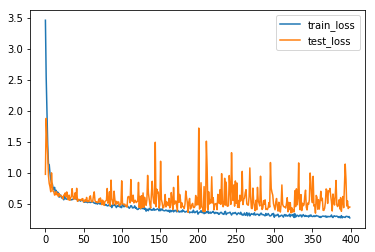

In [15]:
ctx = utils.try_gpu()
num_epochs = 400
learning_rate = 0.01
weight_decay = 5e-5
lr_period = 400
lr_decay = .1

# net = get_simple_net(ctx)
net = net_init(ctx)
#net = get_simple_net(ctx,"mymode")
#net  = vgg_net(ctx)
net.hybridize()
train(net, train_data, valid_data, num_epochs, learning_rate,weight_decay, ctx, lr_period, lr_decay)

In [ ]:
import numpy as np


net = get_simple_net(ctx,"mymode")
net.hybridize()
train(net, train_valid_data, None, num_epochs, learning_rate, weight_decay,
      ctx, lr_period, lr_decay)

### 使用训练好的模型对测试样本进行预测，并保存文本

In [ ]:
outputs = []
for data, label in test_data:
    output = nd.softmax(net(data.as_in_context(ctx)))
    outputs.extend(output.asnumpy())

In [ ]:
test_pre = []

for num in outputs:
    test_pre.append(num[1])
print (len(test_pre)==8424)

In [ ]:
submission = pd.DataFrame({'id': test_json["id"], 'is_iceberg': test_pre})
submission.to_csv("submission.csv", index=False)